In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Load dataset
data = pd.read_csv('./london_weather.csv')

# Show basic info on dataset
print(data.info())
print(data.describe())
print(data.columns)

# Handle missing data
data = data.dropna()

# Data to learn from
X = data.drop(columns=['mean_temp'])

# Target data to predict
y = data['mean_temp']

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardise features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

# Convert to tensors for pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB
None
               date   cloud_cover      sunshine  global_radiation  \
count  1.534100e+04  15322.000000  15341.000000      15322.000000   
mean   1.999567e+07      5.268242      4.350238        118.756951   
std    1.212176e+05      2.070072      4.028339         88.898272

In [2]:
# Class for weather dataset for manipulation
class WeatherDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create training and testing datasets from main dataset
train_dataset = WeatherDataset(X_train_tensor, y_train_tensor)
test_dataset = WeatherDataset(X_test_tensor, y_test_tensor)

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [3]:
import torch.nn as nn

# Define model
class PredictWeatherModel(nn.Module):
    def __init__(self, input_dim):
        super(PredictWeatherModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Init model
input_dim = X_train_tensor.shape[1]
model = PredictWeatherModel(input_dim)

In [4]:
import torch.optim as optim

# Loss + optimizer
# Mean squared error for regression
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# Training loop


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate Model
    # Validation
    model.eval()
    predictions=[]
    actuals=[]
    running_loss = 0.0
    with torch.no_grad():
        for X, y in test_loader:
            output = model(X)
            predictions.extend(output.cpu().numpy().flatten())
            actuals.extend(y.cpu().numpy().flatten())
            loss = criterion(output, y)
            running_loss += loss.item()
        val_loss = running_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
        mse = mean_squared_error(actuals, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)

        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}-RMSE: {rmse:.4f}-MAE: {mae:.4f}-R2: {r2:.4f}")

Epoch 1/10 - Training Loss: 0.9370 - Validation Loss: 0.1089-RMSE: 1.8643-MAE: 1.5005-R2: 0.8928
Epoch 2/10 - Training Loss: 0.0651 - Validation Loss: 0.0396-RMSE: 1.1223-MAE: 0.8866-R2: 0.9612
Epoch 3/10 - Training Loss: 0.0315 - Validation Loss: 0.0280-RMSE: 0.9422-MAE: 0.7426-R2: 0.9726
Epoch 4/10 - Training Loss: 0.0264 - Validation Loss: 0.0262-RMSE: 0.9118-MAE: 0.7194-R2: 0.9744
Epoch 5/10 - Training Loss: 0.0253 - Validation Loss: 0.0249-RMSE: 0.8883-MAE: 0.6964-R2: 0.9757
Epoch 6/10 - Training Loss: 0.0248 - Validation Loss: 0.0249-RMSE: 0.8892-MAE: 0.7045-R2: 0.9756
Epoch 7/10 - Training Loss: 0.0247 - Validation Loss: 0.0243-RMSE: 0.8764-MAE: 0.6848-R2: 0.9763
Epoch 8/10 - Training Loss: 0.0244 - Validation Loss: 0.0249-RMSE: 0.8877-MAE: 0.7012-R2: 0.9757
Epoch 9/10 - Training Loss: 0.0242 - Validation Loss: 0.0243-RMSE: 0.8780-MAE: 0.6874-R2: 0.9762
Epoch 10/10 - Training Loss: 0.0241 - Validation Loss: 0.0242-RMSE: 0.8751-MAE: 0.6870-R2: 0.9764



Final Model Performance:
Root Mean Square Error: 0.88°C
Mean Absolute Error: 0.69°C
R² Score: 0.9764

Sample Predictions vs Actual Values:
Predicted: 16.84°C, Actual: 16.90°C, Difference: -0.06°C
Predicted: 14.84°C, Actual: 15.60°C, Difference: -0.76°C
Predicted: 17.32°C, Actual: 18.90°C, Difference: -1.58°C
Predicted: 7.42°C, Actual: 8.20°C, Difference: -0.78°C
Predicted: 16.72°C, Actual: 17.00°C, Difference: -0.28°C

Error Statistics:
Average Error: -0.08°C
Standard Deviation of Error: 0.87°C
Maximum Overprediction: 2.43°C
Maximum Underprediction: -4.23°C


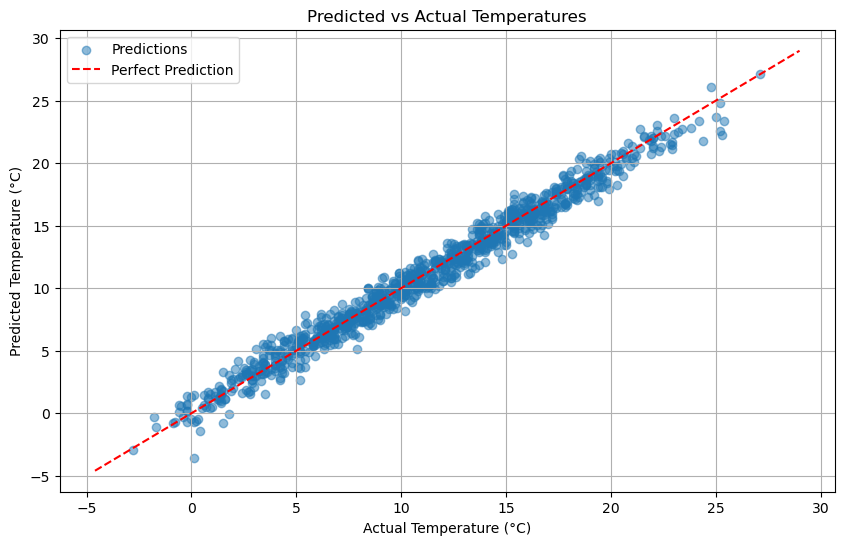

In [6]:

def make_predictions(model, test_loader):
    model.eval()
    all_predictions = []
    actual_values = []

    # Make predictions without calculating gradients
    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            # Store predictions and actual values
            all_predictions.extend(outputs.cpu().numpy().flatten())
            actual_values.extend(y.cpu().numpy().flatten())

    return np.array(all_predictions), np.array(actual_values)


predictions, actuals = make_predictions(model, test_loader)


def analyze_predictions(predictions, actuals):

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print("\nFinal Model Performance:")
    print(f"Root Mean Square Error: {rmse:.2f}°C")
    print(f"Mean Absolute Error: {mae:.2f}°C")
    print(f"R² Score: {r2:.4f}")


    print("\nSample Predictions vs Actual Values:")
    for i in range(5):  # Show first 5 predictions
        print(f"Predicted: {predictions[i]:.2f}°C, Actual: {actuals[i]:.2f}°C, "
              f"Difference: {(predictions[i] - actuals[i]):.2f}°C")


    errors = predictions - actuals
    print(f"\nError Statistics:")
    print(f"Average Error: {np.mean(errors):.2f}°C")
    print(f"Standard Deviation of Error: {np.std(errors):.2f}°C")
    print(f"Maximum Overprediction: {np.max(errors):.2f}°C")
    print(f"Maximum Underprediction: {np.min(errors):.2f}°C")


analyze_predictions(predictions, actuals)

#Visualisation
import matplotlib.pyplot as plt

def plot_predictions(predictions, actuals, num_points=1000):
    plt.figure(figsize=(10, 6))

    # Plot the first num_points predictions
    plt.scatter(actuals[:num_points], predictions[:num_points],
                alpha=0.5, label='Predictions')

    # Plot perfect prediction line
    min_val = min(min(predictions), min(actuals))
    max_val = max(max(predictions), max(actuals))
    plt.plot([min_val, max_val], [min_val, max_val],
             'r--', label='Perfect Prediction')

    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title('Predicted vs Actual Temperatures')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize our predictions
plot_predictions(predictions, actuals)

In [7]:
# Improve model
# Implement Dropout, Batch Normalisation , more layers

class WeatherModel(nn.Module):
    def __init__(self, input_dim):
        super(WeatherModel, self).__init__()

        # First layer
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Second layer
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Third layer
        self.layer3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Output layer
        self.output = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

model = WeatherModel(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)




In [8]:
#Training for Improved model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    predictions = []
    actuals = []
    val_loss = 0.0

    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(y.cpu().numpy().flatten())
            loss = criterion(outputs, y)
            val_loss += loss.item()

    val_loss = val_loss / len(test_loader.dataset)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)



    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}-RMSE: {rmse:.4f}-MAE: {mae:.4f}-R2: {r2:.4f}")



Epoch 1/20 - Training Loss: 1.6902 - Validation Loss: 0.1149-RMSE: 1.9127-MAE: 0.6870-R2: 0.8872
Epoch 2/20 - Training Loss: 0.1093 - Validation Loss: 0.0906-RMSE: 1.6972-MAE: 0.6870-R2: 0.9112
Epoch 3/20 - Training Loss: 0.1027 - Validation Loss: 0.0671-RMSE: 1.4605-MAE: 0.6870-R2: 0.9342
Epoch 4/20 - Training Loss: 0.1031 - Validation Loss: 0.0867-RMSE: 1.6598-MAE: 0.6870-R2: 0.9151
Epoch 5/20 - Training Loss: 0.0934 - Validation Loss: 0.0282-RMSE: 0.9449-MAE: 0.6870-R2: 0.9725
Epoch 6/20 - Training Loss: 0.0927 - Validation Loss: 0.0358-RMSE: 1.0668-MAE: 0.6870-R2: 0.9649
Epoch 7/20 - Training Loss: 0.0990 - Validation Loss: 0.0698-RMSE: 1.4906-MAE: 0.6870-R2: 0.9315
Epoch 8/20 - Training Loss: 0.0859 - Validation Loss: 0.0401-RMSE: 1.1288-MAE: 0.6870-R2: 0.9607
Epoch 9/20 - Training Loss: 0.0926 - Validation Loss: 0.0320-RMSE: 1.0091-MAE: 0.6870-R2: 0.9686
Epoch 10/20 - Training Loss: 0.0885 - Validation Loss: 0.0404-RMSE: 1.1309-MAE: 0.6870-R2: 0.9606
Epoch 11/20 - Training Loss: 


Final Model Performance:
Root Mean Square Error: 1.00°C
Mean Absolute Error: 0.79°C
R² Score: 0.9692

Sample Predictions vs Actual Values:
Predicted: 17.18°C, Actual: 16.90°C, Difference: 0.28°C
Predicted: 15.23°C, Actual: 15.60°C, Difference: -0.37°C
Predicted: 17.12°C, Actual: 18.90°C, Difference: -1.78°C
Predicted: 8.15°C, Actual: 8.20°C, Difference: -0.05°C
Predicted: 16.10°C, Actual: 17.00°C, Difference: -0.90°C

Error Statistics:
Average Error: 0.30°C
Standard Deviation of Error: 0.95°C
Maximum Overprediction: 5.03°C
Maximum Underprediction: -5.29°C


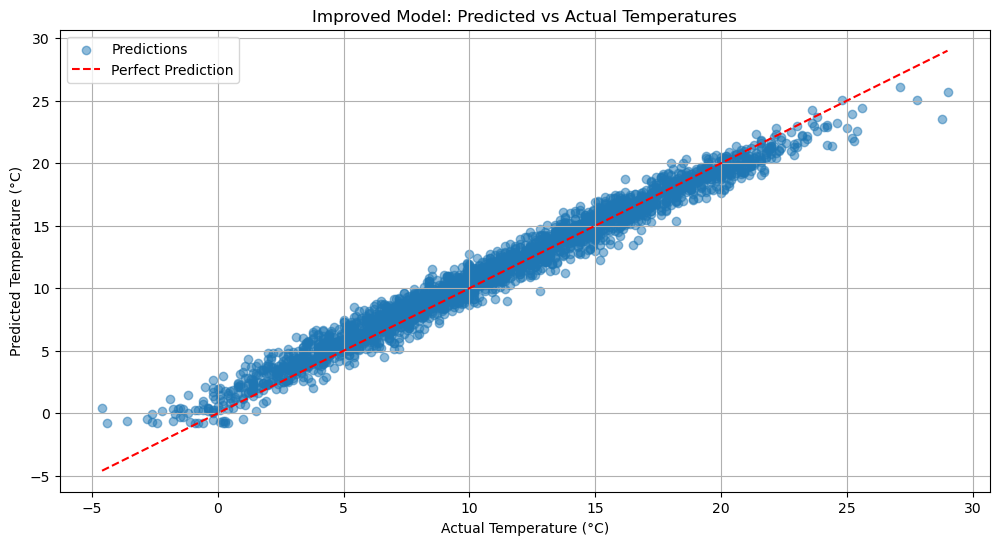

In [9]:
def plot_temperature_predictions_improved(predictions, actuals):
    plt.figure(figsize=(12, 6))

    # Create scatter plot
    plt.scatter(actuals, predictions, alpha=0.5, label='Predictions')
    min_temp = min(min(predictions), min(actuals))
    max_temp = max(max(predictions), max(actuals))
    plt.plot([min_temp, max_temp], [min_temp, max_temp],
             'r--', label='Perfect Prediction')

    # Labels and title
    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title('Improved Model: Predicted vs Actual Temperatures')
    plt.legend()
    plt.grid(True)
    plt.show()

#Predictions
predictions, actuals = make_predictions(model, test_loader)
analyze_predictions(predictions, actuals)
plot_temperature_predictions_improved(predictions, actuals)

In [10]:
# Hyperparameter optimization

In [1]:

# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Training loop
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
    
    return train_losses, val_losses

# Define hyperparameter grid
learning_rates = [0.01, 0.001]
batch_sizes = [16, 32]
epochs = 50

results = {}

# Loop over hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with LR={lr}, Batch Size={batch_size}")

        # Update DataLoader for batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, loss, and optimizer
        model = PredictWeatherModel(input_dim)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train model
        train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs)
        
        # Store results
        results[(lr, batch_size)] = (train_losses, val_losses)

        # Plot Loss vs. Epochs
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.title(f"LR={lr}, Batch Size={batch_size}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

# Compare results for final validation loss
final_losses = {key: val[-1] for key, (_, val) in results.items()}
for key, loss in final_losses.items():
    print(f"LR={key[0]}, Batch Size={key[1]}: Final Validation Loss={loss:.4f}")


Training with LR=0.01, Batch Size=16


NameError: name 'DataLoader' is not defined